**Cell 1: Cài đặt môi trường & Tự động Restart**

In [1]:
# --- CELL 1: SETUP MÔI TRƯỜNG & AUTO-RESTART ---
import os
import sys
import time

# Kiểm tra xem thư viện 'torchtext' đã tồn tại chưa để tránh cài đặt lại không cần thiết
try:
    import torchtext
    import spacy
    print("Môi trường đã sẵn sàng. Bỏ qua bước cài đặt.")
except ImportError:
    print("Đang cài đặt thư viện... (Vui lòng chờ khoảng 1-2 phút)")

    # 1. Cài đặt thư viện:
    # - Sử dụng --no-cache-dir để tránh lỗi 'Hash Mismatch' thường gặp trên Colab.
    # - Ghim phiên bản torch==2.3.1 để tương thích hoàn toàn với torchtext==0.18.0.
    # - portalocker: Thư viện cần thiết để tải các dataset của torchtext.
    !pip install torch==2.3.1 torchtext==0.18.0 torchvision==0.18.1 torchaudio==2.3.1 portalocker>=2.0.0 spacy --no-cache-dir

    # 2. Tải các model ngôn ngữ cho Spacy (Anh & Pháp)
    !python -m spacy download en_core_web_sm
    !python -m spacy download fr_core_news_sm

    print("\n" + "="*50)
    print("ĐÃ CÀI ĐẶT XONG. ĐANG KHỞI ĐỘNG LẠI RUNTIME...")
    print("LƯU Ý: Runtime sẽ crash để reload thư viện mới. Vui lòng bấm 'Run All' lại.")
    print("="*50)

    # 3. Hard Restart Runtime:
    # Buộc Colab khởi động lại kernel để nhận diện thư viện mới cài (xóa sạch biến cũ).
    os.kill(os.getpid(), 9)

Môi trường đã sẵn sàng. Bỏ qua bước cài đặt.


**Cell 2: Tích hợp Preprocessing (Xử lý dữ liệu thô)**

In [3]:
# --- CELL 2: PRE-PROCESSING (CẤU HÌNH PATH & XỬ LÝ DỮ LIỆU) ---
import os
import torch
import spacy
import gzip
import random
from torchtext.vocab import build_vocab_from_iterator
import sys

# ==========================================
# 1. CẤU HÌNH ĐƯỜNG DẪN TỰ ĐỘNG (AUTO-PATH)
# ==========================================
try:
    from google.colab import drive
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    print("[INFO] Môi trường: Google Colab")
    if not os.path.exists('/content/drive'):
        drive.mount('/content/drive')
    # Đường dẫn gốc trên Drive
    BASE_DIR = '/content/drive/MyDrive/NLPProject'
else:
    print("[INFO] Môi trường: Local Machine")
    # Đường dẫn gốc là thư mục hiện tại của dự án
    BASE_DIR = os.getcwd()

# --- ĐỊNH NGHĨA CẤU TRÚC THƯ MỤC THEO CHUẨN ---
DATA_DIR = os.path.join(BASE_DIR, 'data')

# 1. Thư mục chứa dữ liệu thô (.gz) -> data/raw
RAW_DATA_DIR = os.path.join(DATA_DIR, 'raw')

# 2. Thư mục chứa dữ liệu đã xử lý (.pth) -> data/processed
PROCESSED_DIR = os.path.join(DATA_DIR, 'processed')
PROCESSED_FILE = os.path.join(PROCESSED_DIR, 'processed_data.pth')

# Tạo folder nếu chưa có (để tránh lỗi khi save file hoặc load file)
if not os.path.exists(RAW_DATA_DIR):
    os.makedirs(RAW_DATA_DIR)
if not os.path.exists(PROCESSED_DIR):
    os.makedirs(PROCESSED_DIR)

print(f"-> Base Dir:       {BASE_DIR}")
print(f"-> Raw Data Dir:   {RAW_DATA_DIR}")
print(f"-> Processed File: {PROCESSED_FILE}")

# ==========================================
# 2. KHAI BÁO FILE & SPACY
# ==========================================
FILES = {
    'train.en': 'train.en.gz', 'train.fr': 'train.fr.gz',
    'val.en': 'val.en.gz',     'val.fr': 'val.fr.gz',
    'test_2016.en': 'test_2016_flickr.en.gz', 'test_2016.fr': 'test_2016_flickr.fr.gz',
    'test_2017.en': 'test_2017_flickr.en.gz', 'test_2017.fr': 'test_2017_flickr.fr.gz',
    'test_2018.en': 'test_2018_flickr.en.gz', 'test_2018.fr': 'test_2018_flickr.fr.gz',
}

print("\nĐang tải Spacy models...")
try:
    # Tắt ner/parser để load nhanh hơn
    spacy_en = spacy.load('en_core_web_sm', disable=['ner', 'parser'])
    spacy_fr = spacy.load('fr_core_news_sm', disable=['ner', 'parser'])
except OSError:
    print("LỖI: Chưa tìm thấy model Spacy. Hãy đảm bảo Cell 1 đã chạy xong.")
    raise

def tokenize_en(text): return [tok.text for tok in spacy_en.tokenizer(text.lower().strip())]
def tokenize_fr(text): return [tok.text for tok in spacy_fr.tokenizer(text.lower().strip())]

# ==========================================
# 3. HÀM XỬ LÝ DỮ LIỆU
# ==========================================
def read_file(filename):
    # Sử dụng RAW_DATA_DIR (data/raw) để tìm file .gz
    path = os.path.join(RAW_DATA_DIR, filename)
    if not os.path.exists(path):
        # Gợi ý debug chi tiết hơn
        raise FileNotFoundError(f"Lỗi: Không tìm thấy '{filename}' tại '{RAW_DATA_DIR}'.\nHãy chắc chắn bạn đã di chuyển file .gz vào thư mục 'data/raw'.")
    with gzip.open(path, 'rt', encoding='utf-8') as f:
        return [line.strip() for line in f]

def load_and_pair(name_en, name_fr, dataset_name="Data"):
    print(f"Loading {dataset_name}...", end=" ")
    lines_en = read_file(FILES[name_en])
    lines_fr = read_file(FILES[name_fr])
    min_len = min(len(lines_en), len(lines_fr))
    pairs = [(lines_en[i], lines_fr[i]) for i in range(min_len) if lines_en[i] and lines_fr[i]]
    print(f"-> OK ({len(pairs)} cặp).")
    return pairs

def process_data(pairs, vocab_en, vocab_fr):
    data = []
    for src, trg in pairs:
        # Source (EN): Không cần SOS/EOS
        src_tensor = torch.tensor([vocab_en[t] for t in tokenize_en(src)], dtype=torch.long)
        # Target (FR): Cần SOS đầu câu, EOS cuối câu
        trg_tensor = torch.tensor([vocab_fr['<sos>']] + [vocab_fr[t] for t in tokenize_fr(trg)] + [vocab_fr['<eos>']], dtype=torch.long)
        data.append((src_tensor, trg_tensor))
    return data

# ==========================================
# 4. LOGIC CHÍNH (CACHE CHECK)
# ==========================================
if os.path.exists(PROCESSED_FILE):
    print(f"\n[INFO] Tìm thấy dữ liệu đã xử lý: {PROCESSED_FILE}")
    print("Đang tải trực tiếp (Bỏ qua bước xử lý Raw)...")
    saved_data = torch.load(PROCESSED_FILE)
    print("-> Tải thành công!")
else:
    print(f"\n[INFO] Chưa có file processed. BẮT ĐẦU XỬ LÝ TỪ RAW...")
    print(f"(Dữ liệu sẽ được đọc từ: {RAW_DATA_DIR})")

    # Load Raw
    train_pairs = load_and_pair('train.en', 'train.fr', "Train")
    val_pairs = load_and_pair('val.en', 'val.fr', "Val")
    test_2016_pairs = load_and_pair('test_2016.en', 'test_2016.fr', "Test 2016")
    test_2017_pairs = load_and_pair('test_2017.en', 'test_2017.fr', "Test 2017")
    test_2018_pairs = load_and_pair('test_2018.en', 'test_2018.fr', "Test 2018")

    # Build Vocab
    print("Building Vocabulary (Limit: 10k tokens)...")
    vocab_en = build_vocab_from_iterator((tokenize_en(p[0]) for p in train_pairs), min_freq=2, specials=['<unk>', '<pad>', '<sos>', '<eos>'], max_tokens=10000)
    vocab_en.set_default_index(vocab_en['<unk>'])

    vocab_fr = build_vocab_from_iterator((tokenize_fr(p[1]) for p in train_pairs), min_freq=2, specials=['<unk>', '<pad>', '<sos>', '<eos>'], max_tokens=10000)
    vocab_fr.set_default_index(vocab_fr['<unk>'])

    # Tensorize
    print("Converting to Tensors & Saving...")
    saved_data = {
        'vocab_en': vocab_en,
        'vocab_fr': vocab_fr,
        'train_data': process_data(train_pairs, vocab_en, vocab_fr),
        'val_data': process_data(val_pairs, vocab_en, vocab_fr),
        'test_2016_data': process_data(test_2016_pairs, vocab_en, vocab_fr),
        'test_2017_data': process_data(test_2017_pairs, vocab_en, vocab_fr),
        'test_2018_data': process_data(test_2018_pairs, vocab_en, vocab_fr)
    }

    torch.save(saved_data, PROCESSED_FILE)
    print(f"-> Đã xử lý và lưu tại: {PROCESSED_FILE}")

[INFO] Môi trường: Google Colab
-> Base Dir:       /content/drive/MyDrive/NLPProject
-> Raw Data Dir:   /content/drive/MyDrive/NLPProject/data/raw
-> Processed File: /content/drive/MyDrive/NLPProject/data/processed/processed_data.pth

Đang tải Spacy models...

[INFO] Tìm thấy dữ liệu đã xử lý: /content/drive/MyDrive/NLPProject/data/processed/processed_data.pth
Đang tải trực tiếp (Bỏ qua bước xử lý Raw)...
-> Tải thành công!


**Cell 3: DataLoader**

In [4]:
# --- CELL 3: DATALOADER ---
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np

# Load dữ liệu đã cache từ Cell 2
vocab_en = saved_data['vocab_en']
vocab_fr = saved_data['vocab_fr']
train_data = saved_data['train_data']
val_data = saved_data['val_data']

# Lấy Index của token <pad> (Lưu ý: Index này phải giống nhau ở cả 2 vocab hoặc xử lý riêng)
PAD_IDX = vocab_en["<pad>"]

# --- HÀM COLLATE (QUAN TRỌNG) ---
# Hàm này xử lý một list các mẫu đơn lẻ thành một Batch Tensor
def collate_fn(batch):
    # 1. Sắp xếp giảm dần theo độ dài câu nguồn (Source)
    # TẠI SAO? -> Để sử dụng 'pack_padded_sequence' trong Model (giúp RNN bỏ qua tính toán trên padding).
    batch.sort(key=lambda x: len(x[0]), reverse=True)

    src_batch, trg_batch = [], []
    src_len = []

    for src, trg in batch:
        src_batch.append(src)
        trg_batch.append(trg)
        src_len.append(len(src)) # Lưu lại độ dài thật để pack_padded_sequence dùng

    # 2. Padding: Điền thêm <pad> vào các câu ngắn để bằng câu dài nhất trong batch
    # batch_first=True: Output sẽ có dạng (Batch_Size, Max_Seq_Len)
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first=True)

    return src_batch, torch.tensor(src_len, dtype=torch.long), trg_batch

# Dataset Wrapper: Đóng gói list data thành object Dataset của PyTorch
class TranslationDataset(Dataset):
    def __init__(self, data): self.data = data
    def __len__(self): return len(self.data)
    def __getitem__(self, i): return self.data[i]

# --- TẠO DATALOADER ---
BATCH_SIZE = 64

# Train: shuffle=True để xáo trộn dữ liệu mỗi epoch (tránh model học vẹt thứ tự)
train_loader = DataLoader(TranslationDataset(train_data), batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

# Val/Test: shuffle=False để kết quả đánh giá ổn định
val_loader = DataLoader(TranslationDataset(val_data), batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

# Dictionary chứa các Test Loader theo năm
test_loaders = {}
test_names = ['test_2016', 'test_2017', 'test_2018']

for name in test_names:
    # Lấy key data tương ứng từ saved_data (vd: 'test_2016_data')
    data_key = f"{name}_data"
    test_loaders[name.split('_')[1]] = DataLoader( # Chỉ lấy năm làm key (2016, 2017...)
        TranslationDataset(saved_data[data_key]),
        batch_size=BATCH_SIZE,
        shuffle=False,
        collate_fn=collate_fn
    )

print(f"Data Loaded: Train={len(train_data)}, Val={len(val_data)}")
print(f"Test Sets Loaded: {list(test_loaders.keys())}")

Data Loaded: Train=29000, Val=1014
Test Sets Loaded: ['2016', '2017', '2018']


**Cell 4: Thống kê**

In [5]:
# --- CELL 4: THỐNG KÊ & SANITY CHECK (KIỂM TRA TÍNH HỢP LÝ) ---
# Mục đích: Đảm bảo dữ liệu đã load đúng số lượng và các token đặc biệt đã được gán index chính xác.

print("="*45)
print("1. THỐNG KÊ SỐ LƯỢNG MẪU (DATASET SIZE)")
print("="*45)
# Kiểm tra xem dữ liệu có bị load thiếu hay bằng 0 không
print(f"Train:      {len(train_data):>6} mẫu")
print(f"Validation: {len(val_data):>6} mẫu")
print(f"Test 2016:  {len(saved_data['test_2016_data']):>6} mẫu")
print(f"Test 2017:  {len(saved_data['test_2017_data']):>6} mẫu")
print(f"Test 2018:  {len(saved_data['test_2018_data']):>6} mẫu")

print("\n" + "="*45)
print("2. THỐNG KÊ TỪ VỰNG (VOCAB SIZE)")
print("="*45)
# Kích thước này sẽ quyết định kích thước lớp Embedding và lớp Output của Model
print(f"Kích thước Vocab Nguồn (EN): {len(vocab_en):>6} từ")
print(f"Kích thước Vocab Đích  (FR): {len(vocab_fr):>6} từ")

print("\n" + "="*45)
print("3. KIỂM TRA SPECIAL TOKENS (QUAN TRỌNG)")
print("="*45)
# LƯU Ý QUAN TRỌNG:
# - Index của <pad> rất quan trọng cho hàm Loss (ignore_index).
# - Index của <unk> quan trọng để xử lý từ lạ (unknown words).

print(f"{'Token':<10} | {'Index (EN)':<12} | {'Index (FR)':<12}")
print("-" * 40)
specials = ['<unk>', '<pad>', '<sos>', '<eos>']
for tok in specials:
    print(f"{tok:<10} | {vocab_en[tok]:<12} | {vocab_fr[tok]:<12}")
print("-" * 40)

# Kiểm tra cơ chế xử lý từ lạ (Out-of-vocabulary)
# Nếu giá trị này là None -> Code sẽ crash khi gặp từ mới trong tập Test
print(f"Cơ chế UNK (EN): {'ĐÃ BẬT' if vocab_en.get_default_index() is not None else 'TẮT'} (Index: {vocab_en.get_default_index()})")
print(f"Cơ chế UNK (FR): {'ĐÃ BẬT' if vocab_fr.get_default_index() is not None else 'TẮT'} (Index: {vocab_fr.get_default_index()})")

1. THỐNG KÊ SỐ LƯỢNG MẪU (DATASET SIZE)
Train:       29000 mẫu
Validation:   1014 mẫu
Test 2016:    1000 mẫu
Test 2017:    1000 mẫu
Test 2018:    1071 mẫu

2. THỐNG KÊ TỪ VỰNG (VOCAB SIZE)
Kích thước Vocab Nguồn (EN):   5893 từ
Kích thước Vocab Đích  (FR):   6471 từ

3. KIỂM TRA SPECIAL TOKENS (QUAN TRỌNG)
Token      | Index (EN)   | Index (FR)  
----------------------------------------
<unk>      | 0            | 0           
<pad>      | 1            | 1           
<sos>      | 2            | 2           
<eos>      | 3            | 3           
----------------------------------------
Cơ chế UNK (EN): ĐÃ BẬT (Index: 0)
Cơ chế UNK (FR): ĐÃ BẬT (Index: 0)


**Cell 5: Sanity Check**

In [6]:
# --- CELL 5: SANITY CHECK (KIỂM TRA CHẤT LƯỢNG DỮ LIỆU) ---
import random

print("="*45)
print("SANITY CHECK - DECODE TENSOR")
print("="*45)
# Mục đích:
# 1. Đảm bảo Index từ Tensor map ngược lại đúng từ vựng (không bị lỗi lệch index).
# 2. Quan trọng: Kiểm tra xem câu Target có thực sự chứa <sos> ở đầu và <eos> ở cuối không.

def decode_sentence(indices, vocab, remove_specials=False):
    tokens = []
    itos = vocab.get_itos() # Integer-to-String mapping
    for idx in indices:
        token = itos[idx]
        if remove_specials and token in ['<pad>', '<sos>', '<eos>']:
            continue
        tokens.append(token)
    return " ".join(tokens)

# Chọn ngẫu nhiên 1 mẫu trong tập Train
idx = random.randint(0, len(train_data) - 1)
src_tensor, trg_tensor = train_data[idx]
src_list = src_tensor.tolist()
trg_list = trg_tensor.tolist()

print(f"Index mẫu [{idx}]:")
print("-" * 30)

# 1. Kiểm tra Source (Tiếng Anh)
# Kỳ vọng: Chỉ là câu thuần túy, không có <sos> hay <eos> (theo logic Cell 2)
print(f"SOURCE (EN) - Raw Tensor: {src_list}")
print(f"SOURCE (EN) - Decoded   : {decode_sentence(src_list, vocab_en, remove_specials=False)}")

print("-" * 30)

# 2. Kiểm tra Target (Tiếng Pháp)
# Kỳ vọng: BẮT BUỘC phải có <sos> ở đầu và <eos> ở cuối.
# Nếu thiếu -> Model sẽ không học được điểm dừng.
print(f"TARGET (FR) - Raw Tensor: {trg_list}")
print(f"TARGET (FR) - Full Raw  : {decode_sentence(trg_list, vocab_fr, remove_specials=False)}")
print(f"TARGET (FR) - Clean     : {decode_sentence(trg_list, vocab_fr, remove_specials=True)}")

print("-" * 30)
# Kiểm tra nhanh logic
has_sos = (trg_list[0] == vocab_fr['<sos>'])
has_eos = (trg_list[-1] == vocab_fr['<eos>'])
print(f"Check Logic Target: Có <sos> đầu? {'✅' if has_sos else '❌'} | Có <eos> cuối? {'✅' if has_eos else '❌'}")

SANITY CHECK - DECODE TENSOR
Index mẫu [8594]:
------------------------------
SOURCE (EN) - Raw Tensor: [48, 19, 8, 4, 479, 17, 56, 75, 20, 7, 47, 785, 5]
SOURCE (EN) - Decoded   : three people on a cliff are looking out at the water below .
------------------------------
TARGET (FR) - Raw Tensor: [2, 52, 27, 11, 6, 573, 99, 20, 55, 8, 1859, 5, 3]
TARGET (FR) - Full Raw  : <sos> trois personnes sur une falaise regardent l' eau en contrebas . <eos>
TARGET (FR) - Clean     : trois personnes sur une falaise regardent l' eau en contrebas .
------------------------------
Check Logic Target: Có <sos> đầu? ✅ | Có <eos> cuối? ✅


**Cell 6: Định nghĩa Model Baseline**

In [7]:
# --- CELL 6: ĐỊNH NGHĨA MODEL 1 (BASELINE) ---
import torch.nn as nn
import random

# 1. ENCODER: Nén câu nguồn thành Vector ngữ cảnh (Context Vector)
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, emb_dim)
        # batch_first=True: Input shape sẽ là (Batch, Seq_Len, Emb_Dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_len):
        # src: [Batch Size, Src Len]
        embedded = self.dropout(self.embedding(src))

        # KỸ THUẬT PACKING:
        # Giúp LSTM bỏ qua tính toán trên các token <pad>, tăng tốc độ và độ chính xác.
        # Yêu cầu: src_len phải được sort giảm dần (đã làm ở Cell 3 - Dataloader).
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.cpu(), batch_first=True)

        # packed_outputs: Chứa output của mọi time-step (Dùng cho Attention sau này).
        # hidden, cell: Trạng thái ẩn cuối cùng (Context Vector) -> Dùng cho Decoder.
        packed_outputs, (hidden, cell) = self.rnn(packed_embedded)

        return hidden, cell

# 2. DECODER: Giải nén Context Vector thành câu đích từng từ một
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout, batch_first=True)
        self.fc_out = nn.Linear(hid_dim, output_dim) # Layer dự đoán từ tiếp theo
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell):
        # input: [Batch Size] (Chỉ 1 từ tại thời điểm t) -> Cần unsqueeze để thành [Batch, 1]
        input = input.unsqueeze(1)
        embedded = self.dropout(self.embedding(input))

        # Decoder dùng hidden/cell từ bước trước đó (hoặc từ Encoder ở bước đầu tiên)
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))

        # output: [Batch, 1, Hid Dim] -> squeeze -> [Batch, Hid Dim]
        prediction = self.fc_out(output.squeeze(1))
        return prediction, hidden, cell

# 3. SEQ2SEQ: Ghép Encoder và Decoder
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, src_len, trg, teacher_forcing_ratio=0.5):
        # src: [Batch, Src Len], trg: [Batch, Trg Len]
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim

        # Tensor chứa kết quả dự đoán
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)

        # 1. Mã hóa câu nguồn -> Lấy Context Vector (hidden, cell) ban đầu
        hidden, cell = self.encoder(src, src_len)

        # Token đầu tiên đưa vào Decoder luôn là <sos> (trg[:, 0])
        input = trg[:, 0]

        # Vòng lặp giải mã từng từ (Bắt đầu từ 1 vì 0 là <sos> đã biết)
        for t in range(1, trg_len):
            # Dự đoán từ tiếp theo dựa trên input và trạng thái ẩn cũ
            output, hidden, cell = self.decoder(input, hidden, cell)

            # Lưu dự đoán
            outputs[:, t] = output

            # KỸ THUẬT TEACHER FORCING:
            # - True: Dùng từ ĐÚNG trong dataset (trg) làm input cho bước sau.
            # - False: Dùng từ DỰ ĐOÁN (top1) của model làm input cho bước sau.
            # Mục đích: Giúp model học nhanh hơn lúc đầu, nhưng cần tắt dần để tự dự đoán.
            top1 = output.argmax(1)
            input = trg[:, t] if random.random() < teacher_forcing_ratio else top1

        return outputs

**Cell 7: Định nghĩa Model Attention**

In [8]:
# --- CELL 7: ĐỊNH NGHĨA MODEL 2 (ATTENTION - BAHDANAU) ---
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

# 1. ATTENTION LAYER (BAHDANAU / ADDITIVE)
# Mục đích: Tính toán mức độ quan trọng (weight) của từng từ nguồn đối với từ đích đang xét.
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        # Linear layer để chiếu cả Hidden Encoder và Hidden Decoder về cùng không gian
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden: [Batch Size, Dec Hid Dim] (Trạng thái hiện tại của Decoder)
        # encoder_outputs: [Batch Size, Src Len, Enc Hid Dim * 2] (Toàn bộ thông tin câu nguồn)

        src_len = encoder_outputs.shape[1]

        # Lặp lại hidden của decoder src_len lần để khớp kích thước với encoder_outputs
        # hidden: [Batch Size, Src Len, Dec Hid Dim]
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)

        # Tính Energy (Năng lượng khớp lệnh): E = tanh(W * [h_dec; h_enc])
        # energy: [Batch Size, Src Len, Dec Hid Dim]
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))

        # Tính điểm Attention: score = v * E
        # attention: [Batch Size, Src Len]
        attention = self.v(energy).squeeze(2)

        # Softmax để đưa về xác suất (tổng bằng 1)
        return torch.softmax(attention, dim=1)

# 2. ENCODER (BIDIRECTIONAL LSTM)
# Điểm khác biệt: Dùng LSTM 2 chiều để nắm ngữ cảnh cả quá khứ và tương lai.
class EncoderAttention(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        # bidirectional=True: Output sẽ có kích thước gấp đôi (Enc Hid Dim * 2)
        self.rnn = nn.LSTM(emb_dim, enc_hid_dim, bidirectional=True, batch_first=True)
        # Layer nén 2 chiều hidden của Encoder thành 1 chiều hidden cho Decoder
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_len):
        embedded = self.dropout(self.embedding(src))

        # Pack sequence (như model cũ)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len.cpu(), batch_first=True)
        packed_outputs, (hidden, cell) = self.rnn(packed_embedded)

        # Unpack (QUAN TRỌNG): Để Attention layer có thể nhìn thấy toàn bộ các từ (cả pad)
        # outputs: [Batch Size, Src Len, Enc Hid Dim * 2]
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)

        # Xử lý Hidden State ban đầu cho Decoder:
        # hidden[-2]: Lớp Forward cuối cùng
        # hidden[-1]: Lớp Backward cuối cùng
        # Nối lại và đưa qua Linear -> Tanh để tạo hidden state khởi đầu cho Decoder GRU
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))

        return outputs, hidden

# 3. DECODER (GRU + ATTENTION)
# Lưu ý: Ở đây dùng GRU thay vì LSTM để đơn giản hóa trạng thái (chỉ cần hidden, không cần cell).
class DecoderAttention(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        # Input của GRU = Embedding + Weighted Source (Context Vector)
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim, batch_first=True)
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        # input: [Batch Size] -> [Batch Size, 1]
        input = input.unsqueeze(1)
        embedded = self.dropout(self.embedding(input))

        # BƯỚC 1: TÍNH ATTENTION WEIGHTS
        # a: [Batch Size, 1, Src Len]
        a = self.attention(hidden, encoder_outputs).unsqueeze(1)

        # BƯỚC 2: TÍNH CONTEXT VECTOR (WEIGHTED SUM)
        # encoder_outputs: [Batch, Src Len, Enc Hid * 2]
        # weighted = a * encoder_outputs (Phép nhân ma trận bmm)
        # weighted: [Batch Size, 1, Enc Hid Dim * 2] -> Đây là "ý nghĩa" câu nguồn tập trung vào lúc này
        weighted = torch.bmm(a, encoder_outputs)

        # BƯỚC 3: RNN STEP
        # Input cho RNN là: Embedding từ hiện tại + Context Vector từ câu nguồn
        rnn_input = torch.cat((embedded, weighted), dim=2)

        # hidden.unsqueeze(0): GRU yêu cầu hidden shape [Layers, Batch, Hid Dim]
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))

        # BƯỚC 4: DỰ ĐOÁN TỪ TIẾP THEO
        # Kết hợp cả 3 nguồn tin: Output RNN + Context Vector + Embedding -> Linear Layer
        assert (output == hidden.transpose(0, 1)).all() # Kiểm tra GRU output logic

        embedded = embedded.squeeze(1)
        output = output.squeeze(1)
        weighted = weighted.squeeze(1)

        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim=1))

        return prediction, hidden.squeeze(0)

# 4. SEQ2SEQ WRAPPER
class Seq2SeqAttention(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, src_len, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)

        # Encoder trả về:
        # - encoder_outputs: Dùng để tính Attention mỗi bước
        # - hidden: Trạng thái khởi đầu cho Decoder
        encoder_outputs, hidden = self.encoder(src, src_len)

        input = trg[:, 0] # <sos>
        for t in range(1, trg_len):
            # Decoder cần thêm encoder_outputs để "soi"
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            outputs[:, t] = output
            top1 = output.argmax(1)
            input = trg[:, t] if random.random() < teacher_forcing_ratio else top1

        return outputs

**Cell 8: Training & Evaluation Utils**

In [9]:
# --- CELL 8: UTILS (HÀM HỖ TRỢ TRAIN & EVAL) ---
import time
import math
import torch.nn as nn

# 1. KHỞI TẠO TRỌNG SỐ (WEIGHT INITIALIZATION)
# Giúp model hội tụ nhanh hơn thay vì để random mặc định.
# - weight: Khởi tạo theo phân phối chuẩn (Normal Distribution)
# - bias: Khởi tạo bằng 0
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

# 2. ĐẾM SỐ LƯỢNG THAM SỐ
# Giúp kiểm soát độ phức tạp của model.
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# 3. HÀM TRAIN (HUẤN LUYỆN 1 EPOCH)
def train_fn(model, iterator, optimizer, criterion, clip, device):
    model.train() # Bật chế độ train (ảnh hưởng Dropout, BatchNorm)
    epoch_loss = 0

    for i, (src, src_len, trg) in enumerate(iterator):
        src, src_len, trg = src.to(device), src_len.to(device), trg.to(device)

        optimizer.zero_grad() # Xóa sạch gradient cũ trước khi tính mới

        # Forward Pass
        # output shape: [Batch Size, Trg Len, Output Dim]
        output = model(src, src_len, trg)

        # CHUẨN BỊ TÍNH LOSS (QUAN TRỌNG)
        output_dim = output.shape[-1]

        # 1. Cắt bỏ token đầu tiên ([:, 1:])
        # - output: Index 0 là toàn số 0 (do khởi tạo zeros trong model), không chứa dự đoán.
        # - trg: Index 0 là <sos>, model không cần học cách dự đoán chính <sos>.
        # 2. Reshape (Dát phẳng)
        # - Hàm CrossEntropyLoss yêu cầu Input: (N, C) và Target: (N).
        # - Ta gom toàn bộ batch và sequence lại thành 1 danh sách dài để tính toán một thể.
        output = output[:, 1:].reshape(-1, output_dim)
        trg = trg[:, 1:].reshape(-1)

        loss = criterion(output, trg)
        loss.backward() # Lan truyền ngược (Backpropagation)

        # GRADIENT CLIPPING:
        # Giới hạn giá trị gradient để tránh lỗi 'Exploding Gradient' (bùng nổ) thường gặp ở RNN/LSTM.
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step() # Cập nhật trọng số
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

# 4. HÀM EVALUATE (ĐÁNH GIÁ MODEL)
def evaluate_fn(model, iterator, criterion, device):
    model.eval() # Bật chế độ eval (tắt Dropout)
    epoch_loss = 0

    with torch.no_grad(): # Tắt tính toán gradient để tiết kiệm RAM và chạy nhanh hơn
        for i, (src, src_len, trg) in enumerate(iterator):
            src, src_len, trg = src.to(device), src_len.to(device), trg.to(device)

            # LƯU Ý: teacher_forcing_ratio = 0
            # Khi đánh giá, ta phải tắt Teacher Forcing để model tự lực cánh sinh dự đoán từ kế tiếp.
            output = model(src, src_len, trg, 0)

            # Xử lý shape tương tự như train
            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)

            loss = criterion(output, trg)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

# 5. TÍNH THỜI GIAN
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

**Cell 9: Checkpoint Manager**

In [11]:
# --- CELL 9: CHECKPOINT MANAGER (QUẢN LÝ LƯU & TRAIN) ---
import pandas as pd
import os
import torch
import math
import time

# ==========================================
# CẬP NHẬT ĐƯỜNG DẪN (QUAN TRỌNG)
# ==========================================
# Sử dụng BASE_DIR đã định nghĩa ở Cell 2 để tự động thích nghi Colab/Local
CHECKPOINT_DIR = os.path.join(BASE_DIR, 'checkpoints')

# Tạo thư mục nếu chưa tồn tại
if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)
    print(f"[INFO] Đã tạo thư mục checkpoint tại: {CHECKPOINT_DIR}")
else:
    print(f"[INFO] Lưu checkpoint tại: {CHECKPOINT_DIR}")

# 1. HÀM LƯU CHECKPOINT
# Lưu ý: Ta lưu dictionary chứa state_dict (trọng số) thay vì lưu cả object model.
# Điều này giúp file nhẹ hơn và dễ load lại trên các máy khác nhau.
def save_checkpoint(model, optimizer, epoch, loss, filename):
    path = os.path.join(CHECKPOINT_DIR, filename)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),         # Trọng số của model
        'optimizer_state_dict': optimizer.state_dict(), # Trạng thái của optimizer (learning rate, momentum...)
        'loss': loss,
    }, path)
    print(f"-> Đã lưu checkpoint: {path}")

# 2. HÀM LƯU LOG (CSV)
# Dùng để vẽ biểu đồ loss sau này
def save_logs(train_losses, val_losses, filename):
    df = pd.DataFrame({'train_loss': train_losses, 'val_loss': val_losses})
    path = os.path.join(CHECKPOINT_DIR, filename)
    df.to_csv(path, index=False)
    print(f"-> Đã lưu logs: {path}")

# 3. VÒNG LẶP HUẤN LUYỆN CHÍNH (MAIN TRAINING LOOP)
def run_training(model, optimizer, criterion, n_epochs, clip, model_name):
    # Khởi tạo loss tốt nhất là vô cực
    best_valid_loss = float('inf')
    train_losses = []
    valid_losses = []

    print(f"\nBẮT ĐẦU HUẤN LUYỆN MODEL: {model_name}")
    print(f"Tham số: {count_parameters(model):,} parameters")

    for epoch in range(n_epochs):
        start_time = time.time()

        # --- A. Huấn luyện (Train) ---
        train_loss = train_fn(model, train_loader, optimizer, criterion, clip, device)

        # --- B. Đánh giá (Evaluate) ---
        valid_loss = evaluate_fn(model, val_loader, criterion, device)

        end_time = time.time()
        mins, secs = epoch_time(start_time, end_time)

        # Lưu lịch sử loss
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        # --- C. Kiểm tra & Lưu Best Model ---
        # Chỉ lưu model nếu Validation Loss thấp hơn kỷ lục trước đó.
        # Đây là cơ chế "Model Checkpointing" để tránh lấy phải model bị Overfitting ở các epoch cuối.
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            save_checkpoint(model, optimizer, epoch, valid_loss, f'{model_name}_best.pth')

        # --- D. In kết quả ---
        # PPL (Perplexity) = e^(Loss).
        # Ý nghĩa PPL: Độ bối rối của model. PPL càng thấp càng tốt.
        # Ví dụ: PPL = 10 nghĩa là model đang phân vân giữa 10 từ có khả năng cao nhất.
        print(f'Epoch: {epoch+1:02} | Time: {mins}m {secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

    # Lưu toàn bộ lịch sử loss ra file CSV khi chạy xong
    save_logs(train_losses, valid_losses, f'{model_name}_logs.csv')
    return model

[INFO] Lưu checkpoint tại: /content/drive/MyDrive/NLPProject/checkpoints


**Cell 10: Train Baseline**

In [12]:
# --- CELL 10: TRAIN HOẶC LOAD MODEL BASELINE (SEQ2SEQ LSTM) ---
import os
import torch
import torch.nn as nn

# 1. CẤU HÌNH & KHỞI TẠO (HYPERPARAMETERS)
# Các thông số quyết định kiến trúc mạng
INPUT_DIM = len(vocab_en)
OUTPUT_DIM = len(vocab_fr)
ENC_EMB_DIM = 256   # Kích thước vector biểu diễn từ (Word Embedding)
DEC_EMB_DIM = 256
HID_DIM = 512       # Kích thước bộ nhớ (Context Vector) của LSTM
N_LAYERS = 2        # Số lớp LSTM chồng lên nhau (Deep LSTM)
ENC_DROPOUT = 0.5   # Xác suất tắt neuron để chống Overfitting
DEC_DROPOUT = 0.5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Khởi tạo các thành phần
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# Gom lại thành Model hoàn chỉnh và chuyển sang GPU (nếu có)
model_base = Seq2Seq(enc, dec, device).to(device)

# Optimizer Adam: Thường cho kết quả tốt và hội tụ nhanh hơn SGD trong NLP
optimizer = torch.optim.Adam(model_base.parameters(), lr=0.001)

# HÀM LOSS (QUAN TRỌNG):
# ignore_index=PAD_IDX: Bắt buộc phải có.
# Ý nghĩa: Yêu cầu hàm loss bỏ qua, không tính điểm phạt cho các token <pad>.
# Nếu không có dòng này, model sẽ cố gắng học dự đoán padding -> Hiệu suất giảm thê thảm.
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

# Đường dẫn file checkpoint
checkpoint_path = os.path.join(CHECKPOINT_DIR, 'model_baseline_best.pth')

# 2. LOGIC KIỂM TRA: LOAD HAY TRAIN?
# Cơ chế này giúp tiết kiệm thời gian, tận dụng lại model đã train trước đó.
if os.path.exists(checkpoint_path):
    print(f"[INFO] Tìm thấy checkpoint tại: {checkpoint_path}")
    print("Đang load trọng số model...")

    # map_location: Quan trọng khi bạn train trên GPU nhưng lại muốn load thử trên CPU (hoặc ngược lại)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model_base.load_state_dict(checkpoint['model_state_dict'])

    print("-> Load thành công! BỎ QUA TRAINING.")
else:
    print("[INFO] Chưa tìm thấy checkpoint. BẮT ĐẦU HUẤN LUYỆN...")

    # Khởi tạo trọng số (Chỉ chạy khi train mới từ đầu)
    model_base.apply(init_weights)

    N_EPOCHS = 20
    CLIP = 1 # Giới hạn norm của gradient để tránh lỗi bùng nổ gradient (Exploding Gradient)

    # Gọi hàm quản lý training (đã định nghĩa ở Cell 9)
    model_base = run_training(model_base, optimizer, criterion, N_EPOCHS, CLIP, 'model_baseline')

[INFO] Tìm thấy checkpoint tại: /content/drive/MyDrive/NLPProject/checkpoints/model_baseline_best.pth
Đang load trọng số model...
-> Load thành công! BỎ QUA TRAINING.


**Cell 11: Train Attention**

In [13]:
# --- CELL 11: TRAIN HOẶC LOAD MODEL ATTENTION ---
# Mục đích: Khởi tạo và huấn luyện (hoặc load) model Seq2Seq có cơ chế Attention.

import os
import torch

# 1. CẤU HÌNH & KHỞI TẠO
# Lưu ý về kích thước chiều ẩn (Hidden Dimensions):
# - ENC_HID_DIM = 256: Kích thước cho MỘT chiều của Encoder.
# - DEC_HID_DIM = 512: Kích thước của Decoder.
# -> Vì Encoder là Bidirectional (2 chiều), tổng output sẽ là 256 * 2 = 512.
# -> Kích thước này khớp với DEC_HID_DIM, giúp tính toán Attention thuận lợi.
ENC_HID_DIM = 256
DEC_HID_DIM = 512

# Khởi tạo từng thành phần theo thứ tự phụ thuộc:
# 1. Attention Layer (Cầu nối)
attn = Attention(ENC_HID_DIM, DEC_HID_DIM)

# 2. Encoder (Bi-LSTM) & Decoder (GRU + Attention)
enc_attn = EncoderAttention(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec_attn = DecoderAttention(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

# 3. Tổng hợp thành Model Seq2Seq hoàn chỉnh
model_attn = Seq2SeqAttention(enc_attn, dec_attn, device).to(device)

# Optimizer
optimizer_attn = torch.optim.Adam(model_attn.parameters())

# Đường dẫn file checkpoint cho model Attention
checkpoint_path_attn = os.path.join(CHECKPOINT_DIR, 'model_attention_best.pth')

# 2. LOGIC KIỂM TRA: LOAD HAY TRAIN?
print("\n--- MODEL ATTENTION ---")
if os.path.exists(checkpoint_path_attn):
    print(f"[INFO] Tìm thấy checkpoint tại: {checkpoint_path_attn}")
    print("Đang load trọng số model...")
    checkpoint = torch.load(checkpoint_path_attn, map_location=device)
    model_attn.load_state_dict(checkpoint['model_state_dict'])
    print("-> Load thành công! BỎ QUA TRAINING.")
else:
    print("[INFO] Chưa tìm thấy checkpoint. BẮT ĐẦU HUẤN LUYỆN...")
    # Khởi tạo trọng số (quan trọng để model không bắt đầu với số 0)
    model_attn.apply(init_weights)

    N_EPOCHS = 20
    CLIP = 1

    # Chạy huấn luyện và lưu kết quả
    model_attn = run_training(model_attn, optimizer_attn, criterion, N_EPOCHS, CLIP, 'model_attention')


--- MODEL ATTENTION ---
[INFO] Tìm thấy checkpoint tại: /content/drive/MyDrive/NLPProject/checkpoints/model_attention_best.pth
Đang load trọng số model...
-> Load thành công! BỎ QUA TRAINING.


**Cell 12: Inference & Beam Search**

In [14]:
# --- CELL 12: INFERENCE (DỊCH CÂU MỚI) ---
import torch.nn.functional as F

# 1. HÀM BEAM SEARCH (DÀNH RIÊNG CHO MODEL BASELINE)
# Lưu ý: Hàm này được thiết kế cho cấu trúc LSTM (hidden, cell) của Baseline.
# Model Attention dùng logic khác nên hàm translate bên dưới sẽ xử lý riêng.
def beam_search_decode(model, src_tensor, src_len, beam_width=3, max_len=50):
    model.eval()
    with torch.no_grad():
        # Mã hóa câu nguồn -> Lấy trạng thái ẩn ban đầu
        hidden, cell = model.encoder(src_tensor, src_len)

        # Khởi tạo Beam: List các tuple (Score, Tokens, State)
        # Bắt đầu với điểm 0 và token <sos>
        beams = [(0, [vocab_fr['<sos>']], (hidden, cell))]

        for _ in range(max_len):
            new_beams = []
            # Duyệt qua từng ứng viên trong beam hiện tại
            for score, tokens, (hid, cel) in beams:
                last_token = tokens[-1]

                # Nếu ứng viên đã kết thúc bằng <eos>, giữ nguyên nó
                if last_token == vocab_fr['<eos>']:
                    new_beams.append((score, tokens, (hid, cel)))
                    continue

                # Dự đoán bước tiếp theo
                input_tensor = torch.tensor([last_token]).to(device)
                output, new_hid, new_cel = model.decoder(input_tensor, hid, cel)

                # Dùng Log Softmax để tính xác suất (dùng log để cộng thay vì nhân)
                log_probs = F.log_softmax(output, dim=1).squeeze(0)

                # Lấy Top K từ vựng có xác suất cao nhất (beam_width)
                top_scores, top_indices = torch.topk(log_probs, beam_width)

                for s, i in zip(top_scores, top_indices):
                    new_score = score + s.item() # Cộng dồn log-probability
                    new_tokens = tokens + [i.item()]
                    new_beams.append((new_score, new_tokens, (new_hid, new_cel)))

            # Sắp xếp các ứng viên theo điểm cao nhất và chỉ giữ lại 'beam_width' ứng viên
            beams = sorted(new_beams, key=lambda x: x[0], reverse=True)[:beam_width]

            # Nếu tất cả các beam đều đã gặp <eos> thì dừng sớm
            if all(b[1][-1] == vocab_fr['<eos>'] for b in beams):
                break

        # Trả về chuỗi token của beam có điểm cao nhất
        return beams[0][1]

# 2. HÀM DỊCH TỔNG QUÁT (WRAPPER)
def translate_raw_sentence(sentence, model, device, max_len=50):
    model.eval()

    # --- Bước 1: Tiền xử lý (Tokenize) ---
    if isinstance(sentence, str):
        # Nếu là chuỗi text -> Tokenize bằng Spacy
        tokens = [token.text.lower() for token in spacy_en(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    # Thêm <sos> và <eos> vào câu nguồn (theo chuẩn lúc train)
    # Lưu ý: Một số model Encoder không cần <sos>/<eos>, nhưng thêm vào cũng không sao.
    tokens = ['<sos>'] + tokens + ['<eos>']
    src_indexes = [vocab_en[token] for token in tokens]

    # Chuyển thành Tensor và thêm chiều Batch (unsqueeze) -> [1, Seq Len]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    src_len = torch.LongTensor([len(src_indexes)]).to(device)

    # --- Bước 2: Dự đoán (Inference) ---
    with torch.no_grad():
        # A. Đối với Model Baseline: Dùng Beam Search (hoặc Greedy nếu width=1)
        if isinstance(model, Seq2Seq):
             pred_indices = beam_search_decode(model, src_tensor, src_len, beam_width=1)

        # B. Đối với Model Attention: Dùng hàm forward truyền thống (Greedy)
        # Lưu ý: Code này đang tận dụng hàm forward của model train để dự đoán.
        # Nó tương đương với Greedy Decode (lấy max ở mỗi bước).
        elif isinstance(model, Seq2SeqAttention):
             trg_tensor = torch.zeros(1, max_len).long().to(device)
             trg_tensor[0, 0] = vocab_fr['<sos>'] # Khởi đầu bằng <sos>
             # teacher_forcing_ratio=0: Bắt buộc model tự dự đoán từ tiếp theo
             outputs = model(src_tensor, src_len, trg_tensor, teacher_forcing_ratio=0)
             # Lấy index có xác suất cao nhất (Argmax)
             pred_indices = outputs.argmax(2).squeeze().tolist()

    # --- Bước 3: Hậu xử lý (Convert to Text) ---
    itos = vocab_fr.get_itos()
    pred_tokens = []
    for idx in pred_indices:
        token = itos[idx]
        if token == '<eos>': break # Gặp thẻ kết thúc thì dừng
        if token != '<sos>': pred_tokens.append(token)

    # Clean up: Nếu từ đầu tiên là <unk> (không biết), bỏ nó đi cho câu đẹp hơn
    if len(pred_tokens) > 0 and pred_tokens[0] == '<unk>':
        pred_tokens.pop(0)

    return " ".join(pred_tokens)

**Cell 13: BLEU Evaluation**

In [15]:
# --- CELL 13: ĐÁNH GIÁ MODEL (BLEU SCORE) ---
from torchtext.data.metrics import bleu_score
import os
import torch

# 1. HÀM TÍNH BLEU SCORE
# BLEU (Bilingual Evaluation Understudy) đo lường độ trùng khớp n-gram giữa câu máy dịch và câu mẫu.
# Input yêu cầu:
# - candidate (outputs): List các câu dự đoán -> [['i', 'love', 'cat'], ...]
# - references (targets): List các List câu mẫu -> [[['i', 'love', 'cat'], ['i', 'like', 'cat']], ...]
# (Vì một câu nguồn có thể có nhiều cách dịch đúng, nhưng ở đây ta chỉ có 1 tham chiếu).

def calculate_bleu(data_loader, model, vocab_fr, device, method='greedy'):
    targets = []
    outputs = []
    model.eval()

    with torch.no_grad():
        for i, (src, src_len, trg) in enumerate(data_loader):
            src, src_len = src.to(device), src_len.to(device)

            # Lặp qua từng câu trong batch để xử lý (hơi chậm nhưng an toàn cho logic xử lý chuỗi)
            for j in range(src.shape[0]):
                src_sentence = src[j].unsqueeze(0)
                len_sentence = src_len[j].unsqueeze(0)

                # --- A. Dự đoán (Inference) ---
                if method == 'greedy':
                    # Greedy: Chọn từ có xác suất cao nhất ở mỗi bước
                    # Tạo trg_dummy: Chỉ để thỏa mãn tham số đầu vào của hàm forward
                    trg_dummy = torch.zeros(1, 50).long().to(device)
                    # teacher_forcing_ratio = 0: Model tự dự đoán hoàn toàn
                    pred_tensor = model(src_sentence, len_sentence, trg_dummy, 0)
                    pred_tokens = pred_tensor.argmax(2).squeeze().tolist()
                else:
                    # Beam Search: Tìm kiếm chùm (Tốt hơn nhưng chậm hơn)
                    pred_tokens = beam_search_decode(model, src_sentence, len_sentence)

                # --- B. Hậu xử lý (Post-processing) ---
                # 1. Cắt chuỗi tại <eos>: Những từ sau <eos> là vô nghĩa
                try:
                    eos_idx = pred_tokens.index(vocab_fr['<eos>'])
                    pred_tokens = pred_tokens[:eos_idx]
                except ValueError: pass

                # 2. Chuyển Index thành Text & Loại bỏ token rác (<pad>, <sos>)
                itos = vocab_fr.get_itos()
                pred_str = [itos[idx] for idx in pred_tokens if idx not in [PAD_IDX, vocab_fr['<sos>']]]

                # 3. Xử lý câu Target (Đáp án thật) tương tự
                trg_indices = trg[j].tolist()
                try:
                    eos_trg = trg_indices.index(vocab_fr['<eos>'])
                    trg_indices = trg_indices[:eos_trg]
                except: pass
                target_str = [itos[idx] for idx in trg_indices if idx not in [PAD_IDX, vocab_fr['<sos>']]]

                # --- C. Gom data đúng định dạng ---
                outputs.append(pred_str)
                targets.append([target_str]) # Lưu ý: Phải bọc trong list [] vì BLEU hỗ trợ nhiều câu tham chiếu

    # Tính điểm BLEU trên toàn bộ tập dữ liệu
    return bleu_score(outputs, targets)

# 2. HÀM WRAPPER ĐỂ CHẠY TRÊN NHIỀU NĂM (2016, 2017, 2018)
def evaluate_all_datasets(model, test_loaders, vocab_fr, device, model_name, method='greedy'):
    print(f"\n{'='*10} KẾT QUẢ ĐÁNH GIÁ: {model_name} ({method.upper()}) {'='*10}")
    results = {}
    for year, loader in test_loaders.items():
        print(f"Đang đánh giá tập Test {year}...", end=" ")
        # Tính điểm
        score = calculate_bleu(loader, model, vocab_fr, device, method)
        print(f"-> BLEU Score: {score*100:.2f}")
        results[year] = score * 100
    return results

# --- 3. THỰC THI ĐÁNH GIÁ ---

# A. Đánh giá Model Baseline (LSTM Seq2Seq)
path_base = os.path.join(CHECKPOINT_DIR, 'model_baseline_best.pth')
if os.path.exists(path_base):
    print("Đang load Model Baseline...")
    checkpoint = torch.load(path_base)
    model_base.load_state_dict(checkpoint['model_state_dict'])

    # Lưu ý: Baseline thường điểm thấp (~10-15 BLEU)
    evaluate_all_datasets(model_base, test_loaders, vocab_fr, device, "Baseline Model")

# B. Đánh giá Model Attention (GRU + Attention)
path_attn = os.path.join(CHECKPOINT_DIR, 'model_attention_best.pth')
if os.path.exists(path_attn):
    print("\nĐang load Model Attention...")
    checkpoint = torch.load(path_attn)
    model_attn.load_state_dict(checkpoint['model_state_dict'])

    # Lưu ý: Attention thường cải thiện điểm đáng kể (~25-35 BLEU)
    evaluate_all_datasets(model_attn, test_loaders, vocab_fr, device, "Attention Model")

/usr/local/lib/python3.12/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


Đang load Model Baseline...

========== KẾT QUẢ ĐÁNH GIÁ: Baseline Model (GREEDY) ==========
Đang đánh giá tập Test 2016... -> BLEU Score: 27.14
Đang đánh giá tập Test 2017... -> BLEU Score: 20.85
Đang đánh giá tập Test 2018... -> BLEU Score: 14.31

Đang load Model Attention...

========== KẾT QUẢ ĐÁNH GIÁ: Attention Model (GREEDY) ==========
Đang đánh giá tập Test 2016... -> BLEU Score: 44.16
Đang đánh giá tập Test 2017... -> BLEU Score: 35.98
Đang đánh giá tập Test 2018... -> BLEU Score: 27.56


**Cell 14: Plotting**

Đang vẽ biểu đồ so sánh...


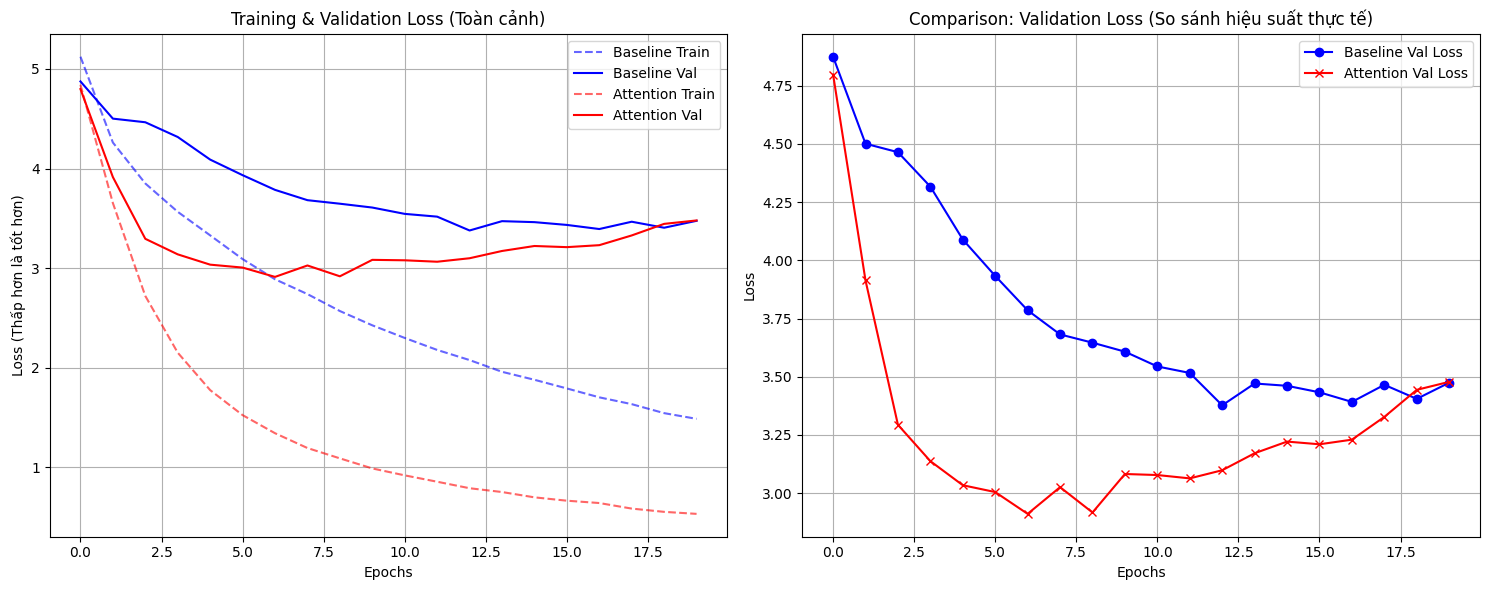

In [16]:
# --- CELL 14: VẼ BIỂU ĐỒ SO SÁNH (VISUALIZATION) ---
import matplotlib.pyplot as plt
import pandas as pd
import os

def plot_learning_curves(baseline_log_path, attn_log_path):
    # 1. Đọc dữ liệu Log từ file CSV (đã lưu ở Cell 9)
    if os.path.exists(baseline_log_path):
        df_base = pd.read_csv(baseline_log_path)
    else:
        print(f"Không tìm thấy log Baseline tại: {baseline_log_path}")
        return

    if os.path.exists(attn_log_path):
        df_attn = pd.read_csv(attn_log_path)
    else:
        print(f"Không tìm thấy log Attention tại: {attn_log_path}")
        return

    # 2. Thiết lập khung vẽ (2 biểu đồ cạnh nhau)
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    # --- BIỂU ĐỒ 1: TỔNG QUAN TRAIN & VAL ---
    # Mục đích: Kiểm tra xem model có bị Overfitting không.
    # - Nét đứt (--): Train Loss (Kết quả lúc học).
    # - Nét liền (-): Val Loss (Kết quả lúc thi).
    # -> Nếu nét đứt giảm sâu mà nét liền đi ngang hoặc tăng lên -> Overfitting.

    # Baseline (Màu Xanh)
    ax[0].plot(df_base['train_loss'], label='Baseline Train', linestyle='--', color='blue', alpha=0.6)
    ax[0].plot(df_base['val_loss'], label='Baseline Val', color='blue')

    # Attention (Màu Đỏ)
    ax[0].plot(df_attn['train_loss'], label='Attention Train', linestyle='--', color='red', alpha=0.6)
    ax[0].plot(df_attn['val_loss'], label='Attention Val', color='red')

    ax[0].set_title('Training & Validation Loss (Toàn cảnh)')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss (Thấp hơn là tốt hơn)')
    ax[0].legend()
    ax[0].grid(True)

    # --- BIỂU ĐỒ 2: SO SÁNH TRỰC TIẾP (VALIDATION ONLY) ---
    # Mục đích: So găng trực tiếp xem ai "thi" tốt hơn (Loss thấp hơn).
    # Kỳ vọng: Đường màu Đỏ (Attention) sẽ thấp hơn và giảm nhanh hơn đường màu Xanh.

    ax[1].plot(df_base['val_loss'], label='Baseline Val Loss', color='blue', marker='o')
    ax[1].plot(df_attn['val_loss'], label='Attention Val Loss', color='red', marker='x')

    ax[1].set_title('Comparison: Validation Loss (So sánh hiệu suất thực tế)')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

# Gọi hàm vẽ
print("Đang vẽ biểu đồ so sánh...")
plot_learning_curves(
    os.path.join(CHECKPOINT_DIR, 'model_baseline_logs.csv'),
    os.path.join(CHECKPOINT_DIR, 'model_attention_logs.csv')
)

**Cell 15: Manual Translation Examples**

In [17]:
# --- CELL 15: VÍ DỤ PHÂN TÍCH LỖI (QUALITATIVE ANALYSIS) ---
import random

def print_examples(data_loader, model_base, model_attn, vocab_en, vocab_fr, device, n=5):
    # 1. Chuyển sang chế độ đánh giá (QUAN TRỌNG: Tắt Dropout)
    model_base.eval()
    model_attn.eval()

    # 2. Lấy 1 batch dữ liệu mẫu từ loader
    # Dùng iter() và next() để lấy nhanh batch đầu tiên trong tập test
    data_iter = iter(data_loader)
    src, src_len, trg = next(data_iter)

    print(f"{'='*20} SO SÁNH KẾT QUẢ DỊCH {'='*20}")
    print("Mục đích: Kiểm tra mắt thường xem Attention có khắc phục được lỗi của Baseline không.")

    for i in range(n):
        # Chọn ngẫu nhiên index của 1 câu trong batch
        idx = random.randint(0, src.shape[0]-1)

        src_indices = src[idx].tolist()
        trg_indices = trg[idx].tolist()

        # 3. Reverse Tokenization (Index -> Text)
        # Lọc bỏ các ký tự đặc biệt (<pad>, <sos>, <eos>) để in ra câu văn sạch sẽ, dễ đọc.
        src_tokens = [vocab_en.get_itos()[x] for x in src_indices if x not in [vocab_en['<pad>'], vocab_en['<sos>'], vocab_en['<eos>']]]
        trg_tokens = [vocab_fr.get_itos()[x] for x in trg_indices if x not in [vocab_fr['<pad>'], vocab_fr['<sos>'], vocab_fr['<eos>']]]

        src_text = " ".join(src_tokens)
        trg_text = " ".join(trg_tokens)

        # 4. Thực hiện dịch (Inference)
        # Gọi lại hàm translate_raw_sentence đã viết ở Cell 12
        pred_base = translate_raw_sentence(src_text, model_base, device)
        pred_attn = translate_raw_sentence(src_text, model_attn, device)

        # 5. In kết quả đối chiếu
        print(f"\nVí dụ {i+1}:")
        print(f"Input (EN):  {src_text}")
        print(f"Target (FR): {trg_text} (Đáp án gốc)")
        # Baseline thường hay gặp lỗi lặp từ hoặc mất từ với câu dài
        print(f"Baseline:    {pred_base}")
        # Attention kỳ vọng sẽ dịch mượt hơn và đầy đủ ý hơn
        print(f"Attention:   {pred_attn}")
        print("-" * 50)

# Chạy thử nghiệm trên tập Test 2016
print_examples(test_loaders['2016'], model_base, model_attn, vocab_en, vocab_fr, device)

==================== SO SÁNH KẾT QUẢ DỊCH ====================
Mục đích: Kiểm tra mắt thường xem Attention có khắc phục được lỗi của Baseline không.

Ví dụ 1:
Input (EN):  a woman uses a drill while another man takes her picture .
Target (FR): une femme utilise une perceuse tandis qu' un autre homme la prend en photo . (Đáp án gốc)
Baseline:    une femme utilise une photo d' un autre homme tandis qu' un homme regarde son visage .
Attention:   une femme utilise une danseuse tandis qu' un autre homme prend la photo
--------------------------------------------------

Ví dụ 2:
Input (EN):  a father - figure and two children outside their home doing yard work such as using a hoe on the grass and planting a tree .
Target (FR): une figure <unk> et deux enfants devant leur maison , faisant des activités de jardinage comme utiliser une binette dans l' herbe et planter un arbre . (Đáp án gốc)
Baseline:    un <unk> et un époux et et enfants sont en l' air , et l' un et l' un d' eux , et un homme 